# LSTM Tutorial - Share Price Prediction (Sequence Prediction)


In [6]:
!pip install pandas
!pip install sklearn
import numpy as np
import pandas as pd 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import Sequential
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


### This section of code is to deal with memory issues on the GPU.

Some have already noticed issues with code throwing up strange errors about lack of memory. This is an unfortunate side effect of using Jupyter notebook as they continue to run in the background unless shutdown explicitly. 

So far we have been using the Tensorflow backend to run our neural network code. By default, Tensorflow will try to reserve a very large chunk of memory at startup to account for all possible situations. 

What this code does is to tell Tensorflow to only increase its memory usage dynamically as it requires. You take a small performance penalty doing this but it will allow you to run multiple programs at the same time.

Do note that every new program that you launch will use up more and more memory. It is still recommended that you shutdown jupyter notebooks that you are not using.

In [7]:
'''# GPU Memory Helper Code
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default''' 

'# GPU Memory Helper Code\nimport tensorflow as tf\nfrom keras.backend.tensorflow_backend import set_session\nconfig = tf.ConfigProto()\nconfig.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU\n\nsess = tf.Session(config=config)\nset_session(sess)  # set this TensorFlow session as the default'

# Define our hyperparameters and global variables

In [8]:
# Hyperparameters and Global Variables
data_dir = "individual_stocks_5yr/"
stock_name = "AAPL_data"
epochs = 5
batch_size = 1
timesteps = 30
train_percentage_split = 0.7

# Load Data

In [9]:
# Load the dataset from file
stock_prices_dataset = pd.read_csv(data_dir + stock_name + ".csv", sep = ',')
stock_prices_dataset.head()

date     open     high      low    close     volume  Name
0  2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL
1  2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL
2  2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL
3  2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL
4  2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL

# Pick Out Just the Data We Want

Let's try predicting the opening share price and grab the date (Just for graphing)

In [10]:
# Get the values we want and reshape the array
dataset = stock_prices_dataset.get('open')

print("The shape of the data before reshape:", dataset.shape)

total_rows=len(dataset)
data = dataset.values
data = data.reshape(total_rows, 1)

print("The shape of the data after reshape:", data.shape)

data_date = stock_prices_dataset.pop('date')

The shape of the data before reshape: (1259,)
The shape of the data after reshape: (1259, 1)


# Scale the Values and Plot the Data

In [11]:
# Scale the values
data = np.float32(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

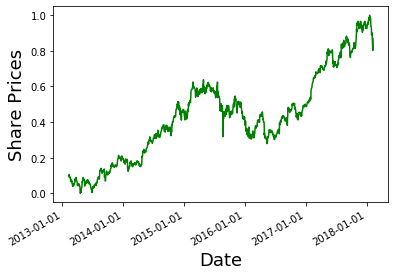

In [12]:

# Needed to fix a depreciated function warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Show the share prices
fig, ax = plt.subplots()
date_time = pd.to_datetime(data_date)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Share Prices',fontsize=18)
ax.plot_date(date_time, data,  'g-')

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

ax.fmt_xdata = DateFormatter('%Y-%m-%d')

fig.autofmt_xdate()
plt.show()

# Reshape the Arrays and Put them Into Time Step Batches

In [13]:
# Splitting the Dataset
splitting_index = int(train_percentage_split * total_rows)

train = data[0:splitting_index, :]
test = data[splitting_index, :]

x_train, y_train = [], []

for i in range(timesteps, len(train)):
    x_train.append(data[i - timesteps:i, 0])
    y_train.append(data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("The format of the dataset", x_train.shape)

The format of the dataset (851, 30, 1)


# Define the LSTM Model

In [14]:
# Create the model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(GRU(units=50))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 50)            7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [15]:
# Define the checkpoint
#checkpoint = ModelCheckpoint('LSTM_Model.h5', monitor='val_loss',
#                             verbose=1, save_best_only=True, save_weights_only=False, mode='min')
#callbacks_list = [checkpoint]

# Train the model
history = model.fit(x_train, y_train, epochs = epochs,
          batch_size = batch_size, verbose=1)

Train on 851 samples
Epoch 1/5
851/851 [==============================] - 75s 88ms/sample - loss: 0.0016 - mae: 0.0226
Epoch 2/5
851/851 [==============================] - 84s 99ms/sample - loss: 4.3926e-04 - mae: 0.0160
Epoch 3/5
851/851 [==============================] - 109s 129ms/sample - loss: 4.2608e-04 - mae: 0.0151
Epoch 4/5
851/851 [==============================] - 78s 91ms/sample - loss: 3.9394e-04 - mae: 0.0147
Epoch 5/5
851/851 [==============================] - 76s 89ms/sample - loss: 3.3980e-04 - mae: 0.0136


# Plot the Losses

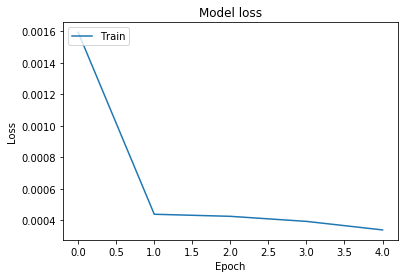

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Make the Prediction

## Load in The Data for Predictions

In [17]:
inputs = dataset[splitting_index - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(timesteps,inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [18]:
closing_price.shape

(378, 1)

# Plot the Predictions

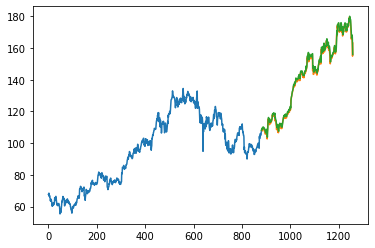

In [19]:
#for plotting
train_plot = stock_prices_dataset.loc[:splitting_index, :]
valid_plot = stock_prices_dataset.loc[splitting_index:, :]
valid_plot = valid_plot.copy()
valid_plot['Predictions'] = closing_price
plt.plot(train_plot['open'])
plt.plot(valid_plot[['open','Predictions']])
plt.show()

# Seems pretty good
Let's try with some different data with the same model

In [20]:
another_stock = 'EW_data'
another_stock_prices_dataset = pd.read_csv(data_dir + another_stock + ".csv", sep = ',')
another_stock_prices_dataset.head()
some_other_data = another_stock_prices_dataset.get('close')

In [21]:
some_other_data = some_other_data[:len(some_other_data) - timesteps]
some_other_data = np.array(some_other_data)
other_inputs = some_other_data.reshape(-1,1)
other_inputs  = scaler.transform(other_inputs)

In [22]:
another_test = []
for i in range(timesteps,other_inputs.shape[0]):
    another_test.append(other_inputs[i-timesteps:i,0])
another_test = np.array(another_test)

another_test = np.reshape(another_test, (another_test.shape[0],another_test.shape[1],1))
other_closing_price = model.predict(another_test)
other_closing_price = scaler.inverse_transform(other_closing_price)

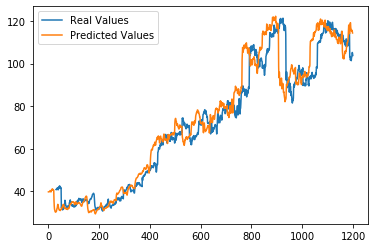

In [23]:
ground_truth = another_stock_prices_dataset.loc[timesteps:len(some_other_data) - timesteps, :]
output = other_closing_price
plt.plot(ground_truth['close'], label="Real Values")
plt.plot(output, label="Predicted Values")
plt.legend()
plt.show()